rBergomi demo
==

We demonstrate the rough Bergomi (rBergomi) price process introduced by [Bayer, Friz and Gatheral](https://ssrn.com/abstract=2554754), which we define here by

$$S_t := \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\},\quad B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2, $$

$$V_t := \xi\ \exp \left\{ \eta Y^a_t - \frac{\eta^2}{2} t^{2a + 1}\right\}, \quad Y_t^a := \sqrt{2a + 1} \int_0^t (t - u)^a  \mathrm{d}W^1_u,$$

for Brownian motion $(W^1, W^2)$. The *hybrid scheme* of [Bennedsen, Lunde and Pakkanen](https://arxiv.org/abs/1507.03004) is used for efficient, $\mathcal{O}(n\log n)$, simulation of the Volterra process, $Y_t^a$.

From $N$ samples of the price process, $\{S^i_t\}_{i = 1}^N$ , we show implied volatilities, $\hat{\sigma}^N_{BS}(k,t)$,  estimated using the following estimator,

$$\hat{\sigma}^N_{BS}(k,t)^2 t = BS^{-1}\left(\hat{C}_N(k,t)\right),\quad \hat{C}_N(k,t) = \frac{1}{N}\sum_{i = 1}^N \max(S^i_t - e^k, 0),$$

as described in [McCrickerd and Pakkanen](https://arxiv.org/abs/1708.02563).

In [1]:
import os
os.chdir('/Users/fionalemon/Documents/Market_Micrstructure/Lemon_rBergomi')

Import required libraries, classes and functions

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rbergomi import rBergomi
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)

import time
%matplotlib inline

A demo of how to simulate a single implied volatility smile is created is shown below

In [3]:
# Create instance of the rBergomi class with $n$ steps per year, N paths, maturity T, roughness index a, where a = H - 0.5
rB = rBergomi(n = 100, N = 30000, T = 1.0 , a = -0.43)

# Generate required Brownian increments
dW1 = rB.dW1()
dW2 = rB.dW2()

Construct the Volterra process, $$Y_t^a := \sqrt{2a + 1} \int_0^t (t - u)^a  \mathrm{d}W^1_u$$

In [4]:
Y = rB.Y(dW1)

Correlate the orthogonal increments, using $\rho$, $$B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2$$

In [5]:
dB = rB.dB(dW1, dW2, -0.9)

Construct the variance process, using $\xi$ and $\eta$, $$V_t := \xi\ \exp \left\{ \eta Y^a_t - \frac{\eta^2}{2} t^{2a + 1}\right\}$$

In [6]:
V = rB.V(Y, xi = 0.235**2, eta = 1.9) 

Finally construct the price process, $$S_t := \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\}$$

In [7]:
S = rB.S(V, dB)

Now replicate implied volatiliies shared by [Bennedsen, Lunde and Pakkanen](https://arxiv.org/abs/1507.03004). Fix the log-strike range, $k$

In [8]:
k = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])

Compute call payoffs, prices, and implied volatilities, $$\hat{\sigma}^N_{BS}(k,t)^2 t = BS^{-1}\left(\hat{C}_N(k,t)\right),\quad \hat{C}_N(k,t) = \frac{1}{N}\sum_{i = 1}^N \max(S^i_t - e^k, 0)$$

In [10]:
ST = S[:,-1][:,np.newaxis]
K = k[np.newaxis,:]
call_payoffs = np.maximum(ST - K,0)
call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
implied_vols = vec_bsinv(call_prices, 1., np.transpose(K), rB.T)

Plot implied volatilities 

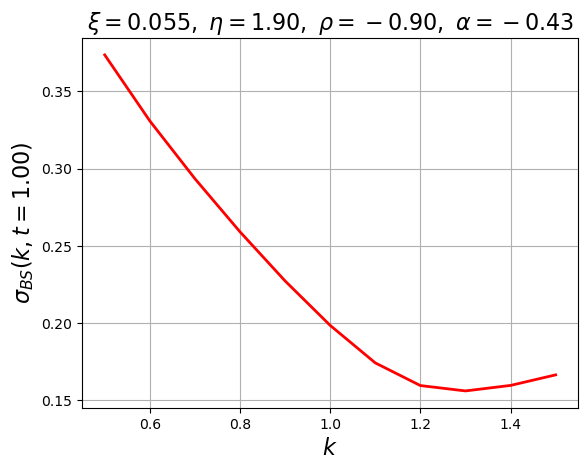

In [11]:
plot, axes = plt.subplots()
axes.plot(k,implied_vols, 'r', lw=2)
axes.set_xlabel(r'$k$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title%(rB.xi, rB.eta, rB.rho, rB.a), fontsize=16)
plt.grid(True)
plt.show()

Now we extend the above implementation to produce an implied volatility grid over strike K and maturity T given a random parameter combination (drawn from uniform distributions)

In [12]:
# H, eta, rho, xi = 0.08628702, 3.19980052, -0.48315778, 0.19590783 use these as reference (as seen on Murgurza's github NN-StochVol-Calibrations)

np.random.seed(8)

maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])
k = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
K = k[np.newaxis,:] # reshape strikes

# Distrubutions chosen in Bayer et. al "On deep calibration of (rough) stochastic volatility models" (2019)
H = np.random.uniform(0.025, 0.5)  # Hurst parameter
eta = np.random.uniform(0.5, 4.0)  # Volatility of volatility
rho = np.random.uniform(-0.95, -0.1)  # Correlation
xi = np.random.uniform(0.01, 0.16)  # Initial variance

implied_vols_matrix = np.zeros((len(maturities), len(k)))

# Start timing the loop
start_time = time.time()

for i, m in enumerate(maturities): 
    rB = rBergomi(n = 100, N = 30000, T = m , a = H - 0.5)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho)
    V = rB.V(Y, xi, eta) 
    S = rB.S(V, dB)
    ST = S[:,-1][:,np.newaxis]
    call_payoffs = np.maximum(ST - K,0)
    call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
    implied_vols = vec_bsinv(call_prices, 1., np.transpose(K), rB.T)

    # Store the computed implied volatilities in the matrix
    implied_vols_matrix[i, :] = implied_vols.flatten()
    
# End timing the loop
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Time taken for the loop: {elapsed_time:.3f} seconds")

Time taken for the loop: 5.379 seconds


In [13]:
# Create a DataFrame with labels for strikes and maturities
implied_vols_df = pd.DataFrame(implied_vols_matrix, index=maturities, columns=k)
implied_vols_df.index.name = 'Maturity'
implied_vols_df.columns.name = 'Strike'
print(f"Parameter set:\nH = {H:.3f}, eta = {eta:.3f}, rho = {rho:.3f}, xi = {xi:.3f}")
print(implied_vols_df)

Parameter set:
H = 0.440, eta = 3.890, rho = -0.211, xi = 0.090
Strike         0.5       0.6       0.7       0.8       0.9       1.0  \
Maturity                                                               
0.1       0.855231  0.657639  0.502259  0.395513  0.320734  0.278843   
0.3       0.521275  0.452941  0.385474  0.324288  0.273354  0.241805   
0.6       0.475971  0.400485  0.336035  0.279186  0.232721  0.206060   
0.9       0.416330  0.348658  0.291348  0.241594  0.201254  0.177028   
1.2       0.348910  0.297240  0.250912  0.209696  0.175283  0.154966   
1.5       0.289890  0.257438  0.222104  0.188000  0.158198  0.139852   
1.8       0.285549  0.245971  0.209752  0.176407  0.148249  0.131004   
2.0       0.265564  0.229312  0.195133  0.164080  0.137870  0.121883   

Strike         1.1       1.2       1.3       1.4       1.5  
Maturity                                                    
0.1       0.278692  0.303053  0.333650  0.371778  0.412883  
0.3       0.246179  0.273871  0.

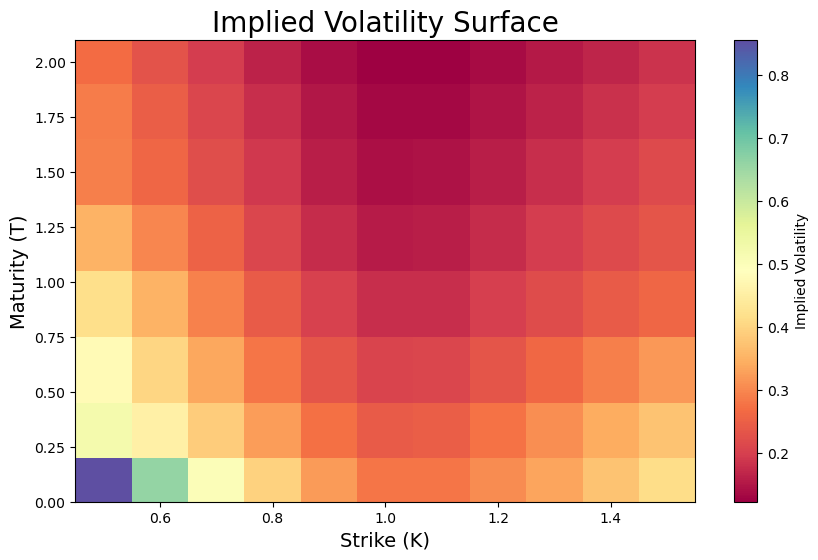

In [17]:
# Plot the implied volatility surface
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(k, maturities, implied_vols_matrix, shading='auto', cmap='Spectral')
ax.set_xlabel('Strike (K)', fontsize=14)
ax.set_ylabel('Maturity (T)', fontsize=14)
ax.set_title('Implied Volatility Surface', fontsize=20)
fig.colorbar(c, ax=ax, label='Implied Volatility')

# Save figure as eps
plt.savefig('implied_volatility_surface.eps', format='eps')
plt.show()

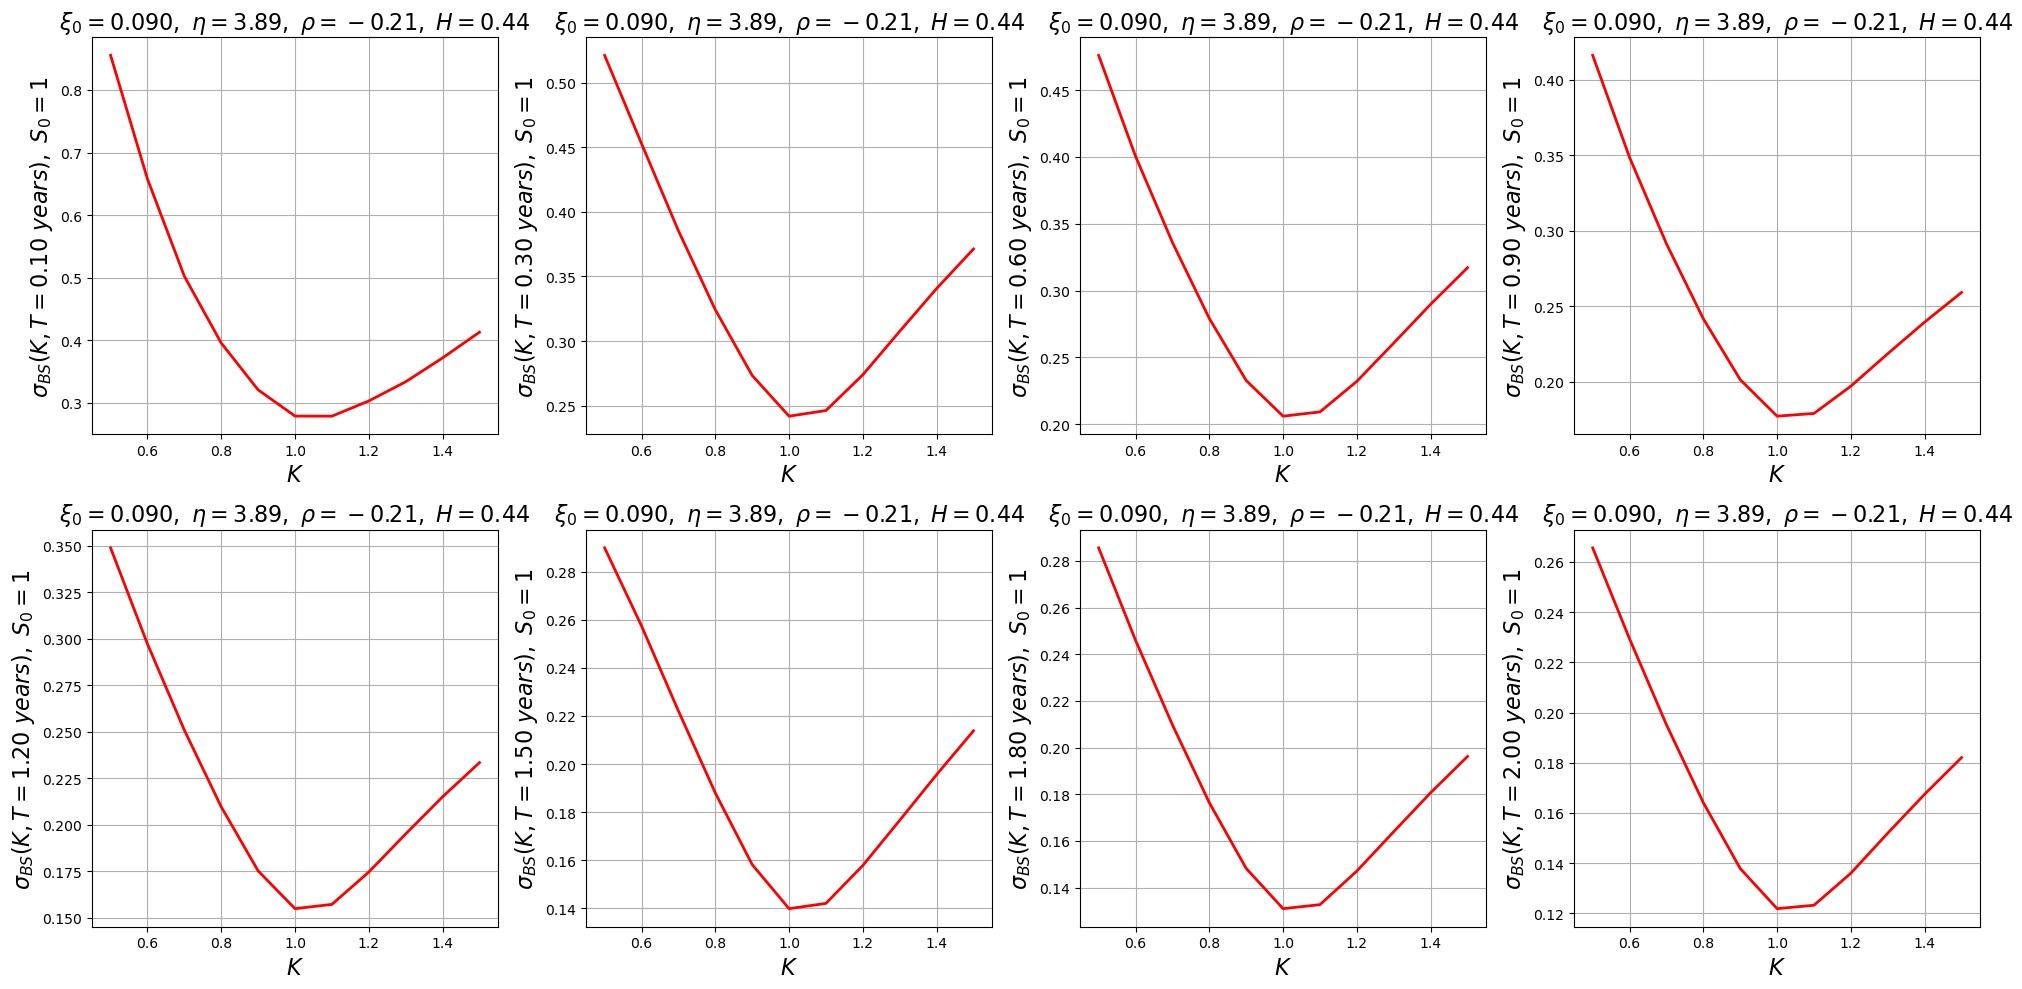

In [15]:
# Plot individual implied volatility curves for each maturity
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (ax, m) in enumerate(zip(axes, maturities)):
    ax.plot(k, implied_vols_matrix[i, :], 'r', lw=2)
    ax.set_xlabel(r'$K$', fontsize=16)
    ax.set_ylabel(r'$\sigma_{BS}(K,T=%.2f \ years),\ S_0 = 1$' % m, fontsize=16)
    title = r'$\xi_0=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ H=%.2f $'
    ax.set_title(title % (xi, eta, rho, H), fontsize=16)
    ax.grid(True)

plt.tight_layout()

# Save figure as eps
plt.savefig('implied_volatility_curves.eps', format='eps')

plt.show()